In [12]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
trees_df = pd.read_csv('county_tree_temp_dwp_prcp_Kent.csv')

In [76]:
trees_df.Biomass.max()

400528.34831446403

<Figure size 720x720 with 0 Axes>

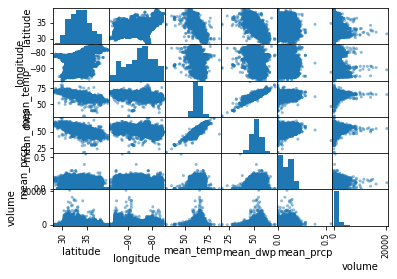

In [15]:
X = trees_df[['species','latitude','longitude','mean_temp','mean_dwp','mean_prcp']]
yb = trees_df['Biomass']
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.3, shuffle=True, random_state=42)
plt.figure(figsize = (10,10))
scatter_matrix(trees_df[['latitude','longitude','mean_temp','mean_dwp','mean_prcp','volume']].loc[trees_df.species == 'loblolly pine'])
plt.show()

In [16]:
columns = ['year','state_code','county_code','species','latitude',
           'longitude','volume','Biomass','number_trees','mean_temp',
           'mean_dwp','mean_prcp']
trees_no_time = trees_df.copy()
trees_no_time = trees_no_time[columns[3:]]

In [17]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

In [18]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    def fit(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            self.scaler.fit(Xreshape)
        else:
            self.scaler.fit(X[self.columns])
        return self
    def transform(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            X[self.columns] = self.scaler.transform(Xreshape)
        else:
            X[self.columns] = self.scaler.transform(X[self.columns])
        return X
    
class Species(BaseEstimator, TransformerMixin):
    def __init__(self, tree):
        self.tree = tree
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.loc[X.species == self.tree]
        return X
    
class Species_enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X.species.to_numpy().reshape(-1,1))
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X.species.to_numpy().reshape(-1,1)).toarray()
        X = X.drop('species',axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X

In [19]:
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', Species_enc())])

In [20]:
X_train_prp = pipe.fit_transform(X_train)

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [109]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [114]:
max_depth = 20
depth_scores = np.empty((19,5))

for i in range(2,21,1):
    dtr = DecisionTreeRegressor(max_depth=i)
    depth_scores[i-2] = list(np.sqrt(-cross_val_score(dtr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


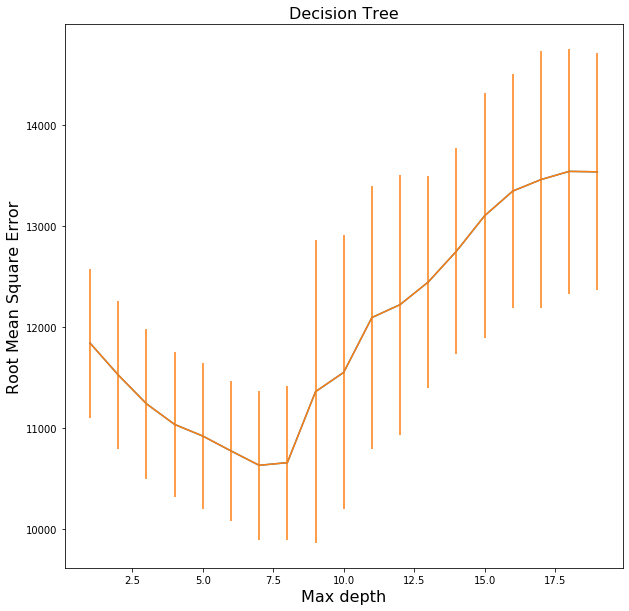

In [115]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,19,19).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,19,19), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Decision Tree',fontsize=16)
plt.show()

In [135]:
max_depth = 20
depth_scores = np.empty((20,5))

for i in range(1,21,1):
    rfr = RandomForestRegressor(n_estimators=100,max_depth=i)
    depth_scores[i-1] = list(np.sqrt(-cross_val_score(rfr, X_train_prp, y_train, scoring="neg_mean_squared_error", cv=5)))
mse_mean = np.mean(depth_scores, axis=1)
mse_stdev = np.std(depth_scores, axis=1)


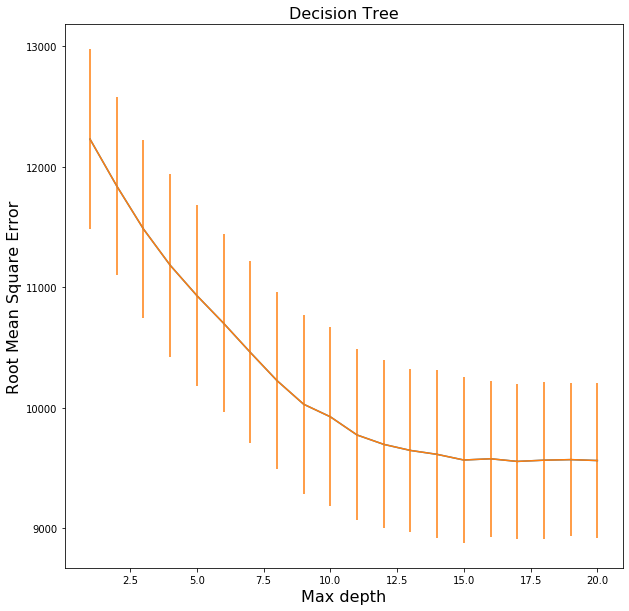

In [137]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,20,20).ravel(),mse_mean.ravel())
plt.errorbar(np.linspace(1,20,20), mse_mean, yerr=mse_stdev)
plt.xlabel('Max depth',fontsize=16)
plt.ylabel('Root Mean Square Error', fontsize=16)
plt.title('Decision Tree',fontsize=16)
plt.show()

In [138]:
mse_stdev

array([749.89362758, 737.46930594, 742.65637734, 759.75636295,
       750.70330087, 737.09271455, 754.89276476, 737.73643406,
       743.75663259, 742.04877715, 710.15117798, 698.70115141,
       676.70039174, 698.00074842, 689.95121496, 648.41883129,
       645.56509694, 652.17375152, 638.46159047, 646.50016145])